In [51]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [52]:
df=pd.read_csv('rainfalldata.csv')

In [53]:
df

,Date,precipitation,temperature,relative humidity,wind speed
0,1990-01-01,0.00,35.72,32.19,6.47
1,1990-02-01,0.00,37.78,31.25,6.55
2,1990-03-01,21.09,38.72,34.81,8.21
3,1990-04-01,0.00,43.05,26.44,8.55
4,1990-05-01,163.48,40.20,61.06,12.24
...,...,...,...,...,...
379,2021-08-01,172.51,30.73,84.81,9.72
380,2021-09-01,260.40,29.59,87.31,10.17
381,2021-10-01,101.75,29.65,84.88,6.49
382,2021-11-01,20.18,29.14,86.25,6.18


Text(0.5, 0, 'parameters')

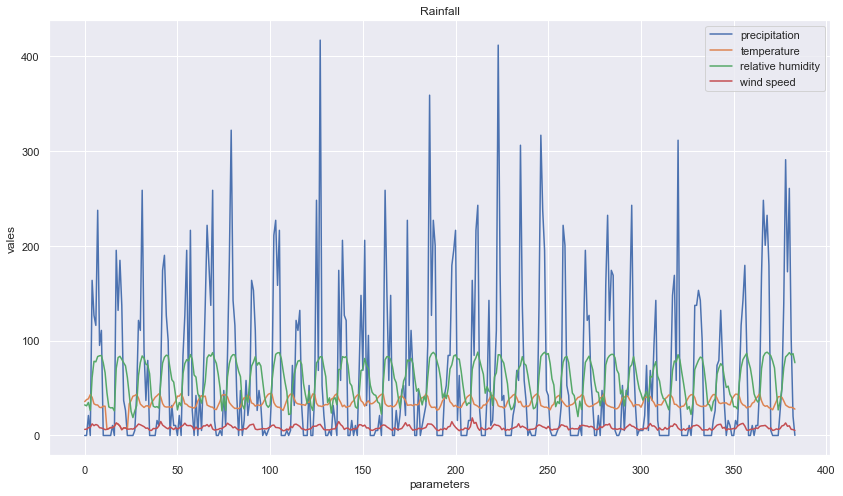

In [54]:
df.plot(kind='line',figsize=(14,8))
plt.title('Rainfall')
plt.ylabel('vales')
plt.xlabel('parameters')

In [55]:
train_dates=pd.to_datetime(df['Date'])

In [56]:
train_dates

0     1990-01-01
1     1990-02-01
2     1990-03-01
3     1990-04-01
4     1990-05-01
         ...    
379   2021-08-01
380   2021-09-01
381   2021-10-01
382   2021-11-01
383   2021-12-01
Name: Date, Length: 384, dtype: datetime64[ns]

In [58]:
cols=list(df)[1:2]
print(cols)

['precipitation']


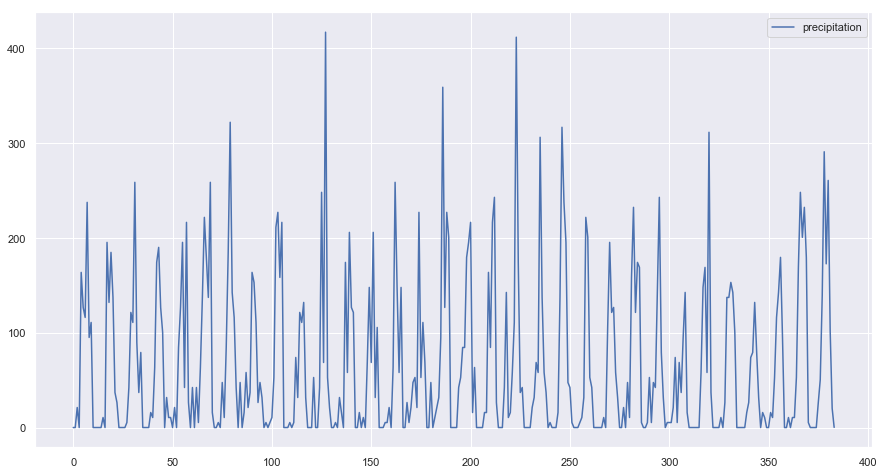

In [59]:
training_df=df[cols].astype(float)
plot_df=training_df
plot_df.plot.line()

In [60]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
scalar=scalar.fit(training_df)
training_df_scaled=scalar.transform(training_df)

In [61]:
#Lists for storing the training data considering multiple variables
#trainX for storing training data (temperature,wind speed,relative humidity)
#trainY for storing target values(rainfall)
trainX=[] 
trainY=[]

n_past=20#20 values will be considered to predict the next values
n_fut=100#for predicting the next 100 value based on previous 20 values


#Adding the values to trainX and trainY lists
for i in range(n_past,len(training_df_scaled)-n_fut+1):
    trainX.append(training_df_scaled[i-n_past:i,0:training_df_scaled.shape[1]])
    trainY.append(training_df_scaled[i+n_fut-1:i+n_fut,0])

#Converting into numpy arrays
trainX,trainY=np.array(trainX),np.array(trainY)

print('trainX shape == {}'.format(trainX.shape))#Knowing the shape 
#(364,20,4) means there are 364windows(groups) of 20*4


print('trainY shape == {}'.format(trainY.shape))
#There are 364 values from previous values

trainX shape == (265, 20, 1)
trainY shape == (265, 1)


In [62]:
model=Sequential()
model.add(LSTM(32,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 32)            4352      
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20, 32)            8320      
                                                                 
 dropout_2 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [63]:
history=model.fit(trainX,trainY,epochs=30,batch_size=5,validation_split=0.2,verbose=1)

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/43 [===========================>..] - ETA: 0s - loss: 1.0903WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000023A79375F28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full

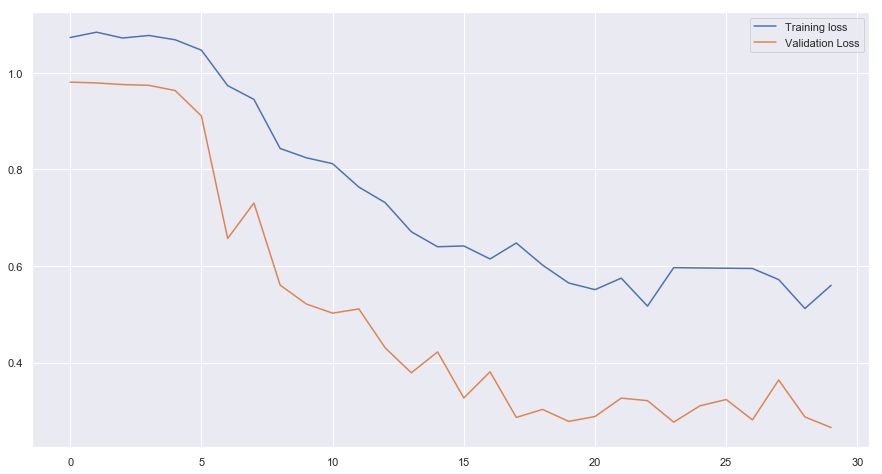

In [64]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

In [65]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past = 1
n_days_for_prediction=100  

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

# make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 1 variables for transform, the inverse expects same dimensions
prediction_copies = np.repeat(prediction, training_df.shape[1], axis=-1)

y_pred_future = scalar.inverse_transform(prediction_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'precipitation':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\lenovo\anaconda3\envs\grl\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\lenovo\anaconda3\envs\grl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\lenovo\anaconda3\envs\grl\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an exp

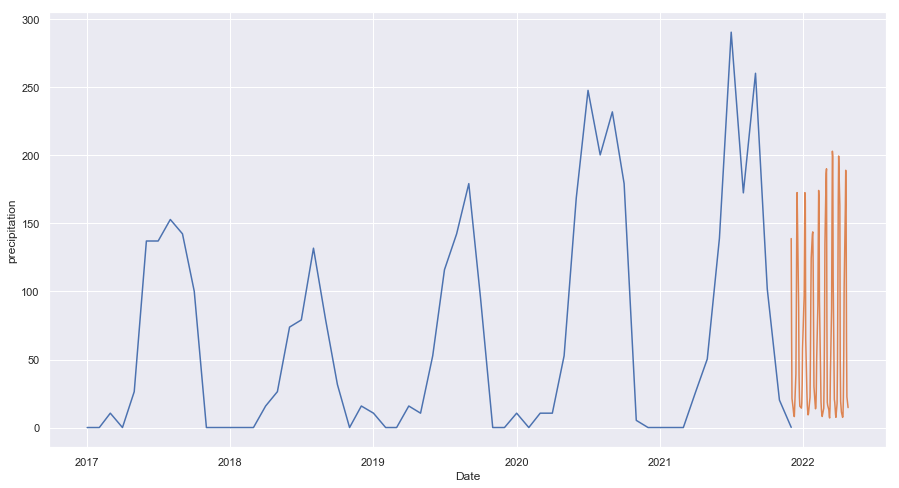

In [66]:
import seaborn as sns

original = df[['Date', 'precipitation']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2017-1-1']

sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(original['Date'], original['precipitation'])
sns.lineplot(df_forecast['Date'], df_forecast['precipitation'])